<div id="toc"> </div>

# Recommending movies from around the world!
## Motivation
One of the potential dangers in recommender systems is also what they are meant to do- recommend you things that you will continue to like. This can lead people to continue liking things they already like with nothing that would inspire them to try something out of their comfort zone. Branching out can lead to diversity in thinking as well as increased empathy. Therefore, the goal of this project is to deliberately use a user's preference to recommend them movies from another country. The user will be able to choose a country, then the recommender will use their preferences to recommend a movie for them from that country. This project was partly inspired by [Book Riot's list of 80 books from the 80 most populated countries in the world](http://bookriot.com/2016/04/28/around-world-80-books-global-reading-list/ "book riot list").

## Getting the data we need

We'll begin by importing some data. We're going to use the [Movielens](https://grouplens.org/datasets/movielens/) dataset, a dataset of user ratings of movies collected by GroupLens Research at the Department of Computer Science and Engineering at the University of Minnesota. 

This dataset comes with the following files:
* `links.csv`: a list of movie ids, along with their IMDB ids. 
* `movies.csv`: a list of movie ids, their title, and their genre
* `ratings.csv`: a list of user ids, the movie id of the movie they rated, the rating they gave it, and the timestamp of when they rated the movie
* `tags.csv`: a list of user created tags 

Unfortunately, the Movielens data doesn't automatically come with the country associated with each movie. That's okay though- we can write some scripts to grab that data for us. We can do this data gathering using [OMDB](http://www.omdbapi.com/), the Open Movie database, whose API allows us to access IMDB data. Luckily, thanks to `links.csv`, we have the IMDB ids, so accessing the data is easy.

In the code snippet below, we can see the first five rows of `links.csv`. We'll be using [pandas](http://pandas.pydata.org/), a data analysis library, for most of our data manipulation... at first.

In [1]:
# pandas library for data analysis (good read reading in and manipulating our CSV files)
import pandas as pd
# we'll need the requests library to make http requests to the OMDB API
import requests

# open links.csv in order to access IMDB id numbers
links_file = pd.read_csv('movie-lens-data/links.csv', dtype={'imdbId': object, 'tmdbId': object})
links_file.head(n=5)

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


We'll do one example of using the `requests` library to get our data from OMDB next.

In [2]:
# get the OMDB API URL
omdb_url = 'http://www.omdbapi.com/?i=tt'

# get the IMDB id for one of our movies
imdb_id = links_file.iloc[0].imdbId

# get the full OMDB url
url = omdb_url + imdb_id
print 'The OMDB URL we will send our request to: %s' % url

# get the countries associated with the movie
response = requests.get(url)
countries = response.json()['Country']
print 'Country associated with movieId %s: %s' %(links_file.iloc[0].movieId, countries)

The OMDB URL we will send our request to: http://www.omdbapi.com/?i=tt0114709
Country associated with movieId 1: USA


Cool, so we found the first movie listed was a movie from the USA! So what movie was it? Since we only have the movie ID, we'll have to JOIN it with the information in `movies.csv` to get the actual movie title.

In [3]:
movies_file = pd.read_csv('movie-lens-data/movies.csv')
movies_file.head(n=5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Oh cool- Toy Story, most definitely a movie from the US! We can add this to our `movies.csv` file so that it will look like:

In [4]:
movies_file.set_value(0, 'country', countries)
movies_file.head(n=5)

,movieId,title,genres,country
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USA
1,2,Jumanji (1995),Adventure|Children|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN


We'll do this for the entire `movies.csv` file. Once we do that, we can take a look at our data.

### Movielens data
Since we're recommending movies by country, we should get a sense of how our data is distributed across countries. I went through the data and got some stats on the countries. Some movies have multiple countries associated with them, marked by 'USA|China|UK', for example, so in these cases I counted the movie as one for each of those countries. 

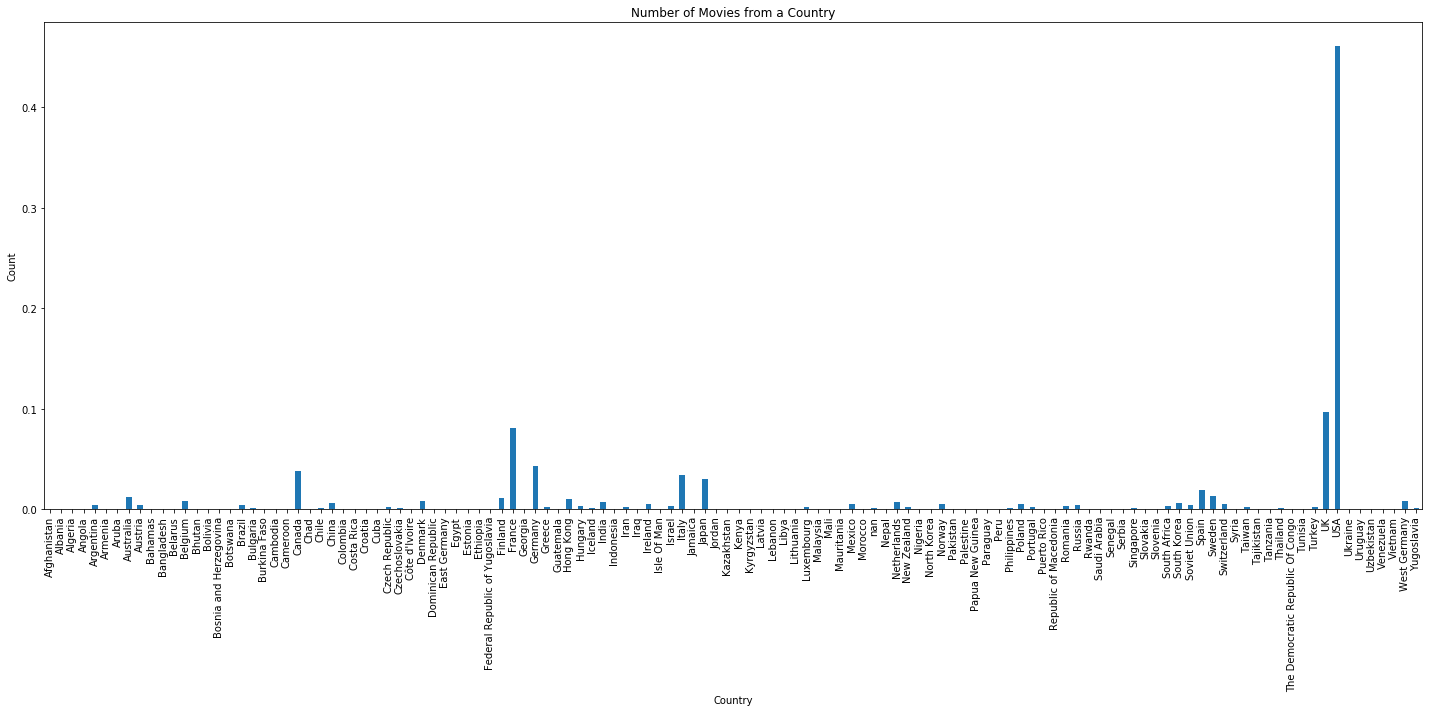

In [5]:
# stuff to make our graph show up in the notebook
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# read in the file I had generated of number of times a country is attributed to a movie
country_stats = pd.read_csv('scripts/output/country-stats-20m.csv')
axes = country_stats.plot(x='country', y='count_percentage', kind='bar', title='Number of Movies from a Country',
                              legend=False)
# set the axes and set display
axes.set_xlabel("Country")
axes.set_ylabel("Count")
plt.tight_layout()
plt.show()

From this plot, it's pretty clear that the Movielens dataset has a huge number of movies from the USA- nearly 50%! After the USA, there are many from the UK, France, and Canada, along with a significant number from Italy, Japan, and Germany. This is important to keep in mind later when we look at what kind of recommendations we get.

## Recommender Types
We're going to try out three different types of recommendation systems:
* Popularity Recommender
* Item Similarity Recommender
* Ranking Factorization Recommender

The following code involves importing the data and splitting it into test and train data. This code will be used for all of the recommender types.


In [6]:
# let's choose a country that we're interested in watching a movie from
country = 'Japan'

# we'll import the ratings.csv which has data in the format of userId, movieId, rating, timestamp
ratings_csv_path = 'movie-lens-data/ratings.csv'
ratings_data = pd.read_csv(ratings_csv_path, encoding='utf-8')
ratings_data.head(n=5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
# now we need a data frame of the data we just got from OMDB that includes the country data
# this file is of the format movieId, title, genres, country
movies_country_csv_path = 'scripts/output/movie-countries.csv'
movies_data = pd.read_csv(movies_country_csv_path, encoding='utf-8', keep_default_na=False)
movies_data.head(n=5)

,movieId,title,genres,country
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USA
1,2,Jumanji (1995),Adventure|Children|Fantasy,USA
2,3,Grumpier Old Men (1995),Comedy|Romance,USA
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,USA
4,5,Father of the Bride Part II (1995),Comedy,USA


In [8]:
from sklearn.model_selection import train_test_split

# split 80% training, 20% testing
training_data, test_data = train_test_split(ratings_data, test_size=0.2, random_state=5)
print "number of ratings in training set: %d " % training_data.shape[0]
print "number of ratings in test set: %d " % test_data.shape[0]

number of ratings in training set: 80003 
number of ratings in test set: 20001 


Alright, now we're ready for each recommender type!

### Popularity Recommender
The popularity recommender does not actually use any machine learning- it simply recommends the most popular items based on previous user ratings. In other words, there is no personalization for the current user- all users receive the same results. The Bookbub list of 80 books is an example of a sort of popularity recommender since everybody is exposed to the same recommendations.

In [9]:
# first we will merge our ratings data with our movie/country data
training_ratings_with_movies = pd.merge(training_data, movies_data, on='movieId').sort_values(by=['userId', 'movieId'])
training_ratings_with_movies.head(n=5)

,userId,movieId,rating,timestamp,title,genres,country
58604,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,USA
7380,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,USA
40865,1,1061,3.0,1260759182,Sleepers (1996),Thriller,USA
43326,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,UK|USA
55844,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,Italy|France


In [10]:
# now we can apply a filter for country on the data set. 
country_filter = training_ratings_with_movies[training_ratings_with_movies.apply(
    lambda x: country in x['country'], axis=1)]
print "total number of movies associated with %s: %d" %(country, country_filter.shape[0])
country_filter.head(n=5)

total number of movies associated with Japan: 1731


,userId,movieId,rating,timestamp,title,genres,country
54241,2,273,4.0,835355779,Mary Shelley's Frankenstein (Frankenstein) (1994),Drama|Horror|Sci-Fi,USA|Japan|UK
74990,4,4006,2.0,949982238,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,USA|Japan
41279,5,5679,4.5,1163374389,"Ring, The (2002)",Horror|Mystery|Thriller,USA|Japan
17027,5,6711,2.5,1163373238,Lost in Translation (2003),Comedy|Drama|Romance,USA|Japan
47176,6,1687,2.0,1109258281,"Jackal, The (1997)",Action|Thriller,USA|UK|France|Germany|Japan


We can do this country filter multiple ways. This first way takes any movie that has Japan associated with it. This next filter only accepts movies where Japan is the sole attributed country. This may be relevant since it seems that many times when a country is attributed as one among many countries, the movie does not actually have much to do with that country. For instance, A Simple Plan was co-financed by international partners from Germany, UK, France and so have these countries attributed to it. This isn't ideal if our goal is to learn about Japan as a country, so the sole filter may be more useful.

In [11]:
sole_country_filter = training_ratings_with_movies.loc[training_ratings_with_movies['country']==country]
print "total number of movies attributed solely to %s: %d" %(country, sole_country_filter.shape[0])
sole_country_filter.head(n=5)

total number of movies attributed solely to Japan: 645


,userId,movieId,rating,timestamp,title,genres,country
8483,6,2019,4.0,1109258270,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,Japan
74884,12,3799,1.0,968045198,Pokémon the Movie 2000 (2000),Animation|Children,Japan
75891,12,3864,3.0,968045015,Godzilla 2000 (Gojira ni-sen mireniamu) (1999),Action|Adventure|Sci-Fi,Japan
8462,15,2019,4.5,1134521638,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,Japan
73081,15,2624,3.0,997939255,After Life (Wandafuru raifu) (1998),Drama|Fantasy,Japan


Okay, now the fun part- let's see what the most popular movies are from Japan.

In [12]:
import numpy as np

popular_movies = sole_country_filter.groupby('title').agg({'rating': [np.size, np.mean]}).sort_values(
    [('rating', 'mean')], ascending=False).reset_index()
popular_movies.head(n=5)

title rating     
                                                       size mean
0  Disappearance of Haruhi Suzumiya, The (Suzumiy...    1.0  5.0
1  Wolf Children (Okami kodomo no ame to yuki) (2...    1.0  5.0
2                                   Wild Zero (2000)    1.0  5.0
3              Maborosi (Maboroshi no hikari) (1995)    1.0  5.0
4                                    Burn Up! (1991)    1.0  5.0

This isn't ideal- these movies that have only one rating are getting really high ratings since one person gave them a five star. That's hardly what popular means! We could apply some sort of algorithm in order to get a better 'popularity' score. The function below is adapted from [Evan Miller's post](http://www.evanmiller.org/how-not-to-sort-by-average-rating.html) on how to get a more accurate rating. 

In [13]:
from math import sqrt

def wilson_score(num_positive_ratings, num_ratings):
    # we'll default to a 95% confidence level
    if num_ratings == 0:
        return 0
    # this is a z score, since we're using a 95% confidence level, z will always be 1.96
    z = 1.96
    phat = 1.0 * num_positive_ratings / num_ratings
    return (phat + z*z/(2*num_ratings) - z * 
            sqrt((phat*(1-phat)+z*z/(4*num_ratings))/num_ratings))/(1+z*z/num_ratings)
    
wilson_score(80, 100)

0.7111690380734976

In [14]:
# here's a function to help us determine what a 'positive' rating is
def number_positive_ratings(x):
    pos = x[x >= 3]
    return pos.size
    
# make our data frame show us the number of positive ratings, as well as number overall ratings 
# grouped by movie title    
grouped_ratings = sole_country_filter.groupby('title').agg({
        'rating': [number_positive_ratings, np.size]}).reset_index()

# apply the wilson score function now that we have number of positive ratings and number of overall ratings
grouped_ratings['wilson score'] = np.vectorize(wilson_score)(grouped_ratings['rating']['number_positive_ratings'], 
                                                             grouped_ratings['rating']['size'])

# let's see what's popular in Japan!
grouped_ratings[['title','wilson score']].sort_values('wilson score', ascending=False).head(n=5)


,title,wilson score
,,
119,Seven Samurai (Shichinin no samurai) (1954),0.838607
123,Spirited Away (Sen to Chihiro no kamikakushi) ...,0.828371
78,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,0.824115
106,Princess Mononoke (Mononoke-hime) (1997),0.811068
67,Howl's Moving Castle (Hauru no ugoku shiro) (2...,0.804555


Nice- this list of movies looks a lot more reasonable. The Wilson Score tells us how confident we are that ratings for this movie is positive. Movies 2-5 in this list are all highly acclaimed Miyazaki movies which even I've heard of before. I had never heard of Seven Samurai, but the [Seven Samurai Wikipedia](https://en.wikipedia.org/wiki/Seven_Samurai) page says:
> Since its release, Seven Samurai has consistently ranked highly in critics' lists of the greatest films, such as the BFI's Sight & Sound and Rotten Tomatoes polls. It has remained highly influential, often seen as one of the most "remade, reworked, referenced" films in cinema.

So it seems like we are indeed getting popular movies back!

### Item Similary Recommender
Alright, let's move on and try to get some personalization with our recommendations. The next method we are going to use is the Item Similarity Recommender. What this means is that you tell the model the movies you like, and the model will go and try to find the movies that are the most similar to the ones that you liked and return them to you.

To create the model, we take in our user ratings file. The model will compute the similarity between movies by associating movies that a user has watched before and enjoyed as similar. The similarity function is often a Cosine or Pearson similarity function.

[Ethan Rosenthal's blog post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) was very helpful in this effort.


In [15]:
# we'll need some more helper functions 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

num_users = ratings_data.userId.unique().shape[0]
num_movies = ratings_data.movieId.unique().shape[0]
print "Number of unique users: %d" % num_users
print "Number of unique movies: %d" %num_movies


Number of unique users: 671
Number of unique movies: 9066


The next step is that we need to make a matrix with dimensions num_users x num_movies. This will be our user-item matrix. The idea is that we can fill in the value between a user and an item as the rating the user gave that item, and from there we want to be able to fill in (or predict) the missing ratings.

Our matrix is going to be dimension num_users x num_movies. While userId goes from 1 to num_users, the range of num_movies is actually very large, as there are thousands of movies in the Movielens dataset, but since they only included data for users who rated over 20 movies, and because this is their smaller dataset, there are a lot of missing movieIds. So ideally we want a map that goes from 1 to num_movies, where each index maps to a movieId. In other words, we could have movies with IDs ranging from 1 to 999,999 even if there aren't 999,999 movies in the dataset. If there were only two movies in our dataset with movieIds 1 and 999,999, we only want our matrix to be num_users x 2, not num_users x 999,999.

In [16]:
# function to make a movie map out of our list of movies
def get_index_movie_map(data):
    movie_map = {}
    no_duplicates = data.movieId.unique()
    index = 0
    for movieId in no_duplicates:
        movie_map[movieId] = index
        index = index + 1

    return movie_map

movie_map = get_index_movie_map(ratings_data)
print "Index 1 maps to movieId %d in movie_map" % movie_map[1]
print "Index 2 maps to movieId %d in movie_map" % movie_map[2]

Index 1 maps to movieId 417 in movie_map
Index 2 maps to movieId 650 in movie_map


Nice- now we can make our num_users by num_movies matrix.

In [17]:
# function to create the user-item matrix
def get_user_item_matrix(n_users, n_items, data, movie_map):
    """Returns the user item matrix for a given set of data"""
    matrix = np.zeros((n_users, n_items))
    for line in data.itertuples():
        matrix[line[1]-1, movie_map[line[2]]] = line[3]

    return matrix

# matrix for training data
train_data_matrix = get_user_item_matrix(num_users, num_movies, training_data, movie_map)
# matrix for test data (to use later)
test_data_matrix = get_user_item_matrix(num_users, num_movies, test_data, movie_map)
print train_data_matrix.shape
train_data_matrix[:10, :10]




(671, 9066)


array([[ 2.5,  3. ,  3. ,  2. ,  4. ,  2. ,  2. ,  0. ,  3.5,  2. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3. ,  0. ,  0. ,  0. ,  0. ,  0. ,  4. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

Along the y axis of this array we have the users, and along the x axis we have the movie. Most of these are zeros, as expected, since there are far more movies than users- any given user has probably only rated a small percentage of the total number of movies. We should also keep in mind that the zeros in the array are not actually a zero rating- they are just an empty rating.

Now we can find our cosine similarities. We can treat each column in the matrix as a vector- how similar two items are is "depedent upon the ratings given to the items by users who have rated both of them"[1]

![item similarity picture](figures/itembased.png "Item Similarity Picture")

The equation for cosine similarity [2]:
![cosine similarity](figures/cosine_sim.svg "cosine similarity")

We can implement this as a for loop in Python, but it takes quite a while so instead we'll use [sklearn's pairwise distance function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html).

[[1] Carleton CS](http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html)

[[2] Cosine similarity wikipedia page](https://en.wikipedia.org/wiki/Cosine_similarity)



In [18]:
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')
print item_similarity.shape
item_similarity[:4,:4]


(9066, 9066)


array([[ 1.        ,  0.09056634,  0.1951328 ,  0.15563275],
       [ 0.09056634,  1.        ,  0.12314943,  0.13291486],
       [ 0.1951328 ,  0.12314943,  1.        ,  0.29479334],
       [ 0.15563275,  0.13291486,  0.29479334,  1.        ]])

Time to make predictions! In order to make predictions, we use weighted sums.
![prediction formula](figures/prediction_formula.jpg "prediction formula")[3]

In this formula, the $\sum r(U_i, I_t)$ term is the rating given by user $U$ to item $I$- the sum means it's the sum of all of the similar items. We multiply this term by the similarity to the new user (represented by $NU$) to the user $U$. Then we divide in order to scale the prediction. This formula is basically saying to weigh the new user's rating for each item by its similarity to the target item.

[[3] Depaul CS](http://facweb.cs.depaul.edu/mobasher/classes/csc575/assignments/knn-predictions.html)


In [19]:
def predict(ratings, similarity):
    prediction = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return prediction
    
item_prediction = predict(train_data_matrix, item_similarity)
print(item_prediction.shape)
item_prediction[:4,:4]

(671, 9066)


array([[ 0.02239844,  0.01686493,  0.02340005,  0.01911031],
       [ 0.0966897 ,  0.0569284 ,  0.07077216,  0.05073234],
       [ 0.04460545,  0.02819706,  0.0417272 ,  0.03450233],
       [ 0.21692166,  0.22131305,  0.23734185,  0.23076399]])

Wow- we're back to the shape of the matrix we started with (num_users x num_movies) but now we have all of the numbers in the matrix filled in. Now we should test against the test data to see how well we're doing.

In [20]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    max_prediction_score = max(prediction)
    normalized_prediction = [float(i)*5/max_prediction_score for i in prediction]
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(normalized_prediction, ground_truth))

print "Training data RMSE: %s" % str(rmse(item_prediction, train_data_matrix))
print "Test data RMSE: %s" % str(rmse(item_prediction, test_data_matrix))


Training data RMSE: 3.21547994515
Test data RMSE: 3.20090096776


Neat- our training and test RMSE's are pretty close. It's still hard to say intuitively if that means anything though, so let's look at some actual movies.

In [27]:
# function to get the key from the value in the movie map
def get_movie_id_from_index(search_id, movie_map):
    for index, movie_id in movie_map.iteritems():
        if movie_id == search_id:
            return index

# quick test to make sure our reverse map is working right
map_input = 1
map_output = movie_map[map_input]
assert(get_movie_id_from_index(map_output, movie_map) == map_input)

# function to get a list of movies most similar to one movie index. 
# we have to do a bit of extra processing because of our earlier movie map
def top_k_movies(similarity, movie_map, movie_idx, k=5):
    adjusted_movie_idx = movie_map[movie_idx]
    return [get_movie_id_from_index(x, movie_map) for x in np.argsort(similarity[adjusted_movie_idx,:])[:-k-1:-1]]

movie_id = 1 # this is Toy Story
top_similar_movies = top_k_movies(item_similarity, movie_map, movie_id, k=5)

# display the results in a data frame
top_similar_movies_df = pd.DataFrame({'movieId': pd.Series(top_similar_movies)})
pd.merge(top_similar_movies_df, movies_data, on='movieId')


,movieId,title,genres,country
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USA
1,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,USA
2,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,USA
3,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,USA
4,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,USA


Hey, I'd say that's not bad! Toy Story is for sure very similar to Toy Story 2, and I'd say Shrek and Monsters Inc. are as well. I'm not sure about Independence Day, but overall we can see that we are indeed getting similar movies.

Now let's make some actual predictions based on user information.

In [28]:
# function to get a list of movies most similar to one user index. 
# we have to do a bit of extra processing because of our earlier movie map
def top_k_movies_for_user(prediction, movie_map, user_idx, k=5):
    return [get_movie_id_from_index(x, movie_map) for x in np.argsort(prediction[user_idx,:])[:-k-1:-1]]

my_movie_ratings = pd.read_csv('test-data/my_movie_ratings.csv')
my_movie_ratings

,movieId,title,rating
0,1,Toy Story,5
1,123,Chungking Express,4
2,4144,In the mood for love,5
3,103141,Monsters University,4
4,106916,American hustle,3
5,107141,saving mr banks,3
6,31658,howl's moving castle,4
7,81845,king's speech,5
8,152081,zootopia,5
9,6942,love actually,4


In [23]:
from calendar import timegm
from datetime import datetime

def prepare_new_user_data(new_data, ratings_data):
    # get rid of the title column in my data- just put that there for readability
    prepared_data = new_data.drop('title', axis=1)
    new_user_id = ratings_data['userId'].unique().shape[0] + 1
    prepared_data['userId'] = new_user_id
    current_time = timegm(datetime.utcnow().utctimetuple())
    prepared_data['timestamp'] = current_time
    return prepared_data

prepared_data = prepare_new_user_data(my_movie_ratings, ratings_data)
prepared_data

,movieId,rating,userId,timestamp
0,1,5,672,1493440233
1,123,4,672,1493440233
2,4144,5,672,1493440233
3,103141,4,672,1493440233
4,106916,3,672,1493440233
5,107141,3,672,1493440233
6,31658,4,672,1493440233
7,81845,5,672,1493440233
8,152081,5,672,1493440233
9,6942,4,672,1493440233


Now that we have prepared my new ratings, we go through the same thing as before. This will be a good review of how we put everything together!

In [29]:
# first append my data to the overall data. we'll use the entire data set this time
additional_data = ratings_data.append(prepared_data)

# create our user item matrix but add one to the number of users for me
additional_data_matrix = get_user_item_matrix(num_users+1, num_movies, ratings_data, movie_map)

# find the similarity matrix
additional_data_item_similarity = 1 - pairwise_distances(additional_data_matrix.T, metric='cosine')

# create the prediction matrix
additional_data_prediction = predict(additional_data_matrix, additional_data_item_similarity)

# find the top movies from the prediction matrix
my_index = 672 - 1 # matrix is index 0
my_top_movies = top_k_movies_for_user(additional_data_prediction, movie_map, my_index, k=num_movies)

# display the results in a data frame
my_top_movies_df = pd.DataFrame({'movieId': pd.Series(my_top_movies)})
my_results = pd.merge(my_top_movies_df, movies_data, on='movieId')

# output
my_results.head(n=10)

,movieId,title,genres,country
0,6425,"6th Man, The (Sixth Man, The) (1997)",Comedy,USA
1,4054,Save the Last Dance (2001),Drama|Romance,USA
2,4114,"Good Morning, Babylon (1987)",Drama,Italy|France|USA
3,3677,Baraka (1992),Documentary,USA
4,2131,Autumn Sonata (Höstsonaten) (1978),Drama,France|West Germany|Sweden|UK
5,2092,"Return of Jafar, The (1994)",Adventure|Animation|Children|Fantasy|Musical|R...,USA
6,2075,Mephisto (1981),Drama|War,West Germany|Hungary|Austria
7,4069,"Wedding Planner, The (2001)",Comedy|Romance,Germany|USA
8,3564,"Flintstones in Viva Rock Vegas, The (2000)",Children|Comedy,USA
9,4862,Not Without My Daughter (1991),Drama,USA


In [31]:
# and if we only recommend movies from the indicated country...
my_results.loc[my_results['country']==country].head()

,movieId,title,genres,country
145,5534,Hush! (2001),Drama,Japan
310,107953,Dragon Ball Z: Battle of Gods (2013),Action|Animation|Fantasy|IMAX,Japan
338,83132,"Secret World of Arrietty, The (Kari-gurashi no...",Animation|Children|Fantasy,Japan
341,84187,Evangelion: 2.0 You Can (Not) Advance (Evanger...,Action|Animation|Drama|Sci-Fi,Japan
344,84952,Confessions (Kokuhaku) (2010),Drama|Horror,Japan


Would I like these movies? I'm not sure, mostly because I haven't seen any of them before. So I can't say whether or not these results are satisfying, but hopefully with the low difference between training and test RMSEs as well as proof that we get similar movies from Toy Story, I've shown a bit how we've learned to recommend similar items.

I implemented this using the libraries we have already been using, but building the model proved pretty memory intensive on my computer, even with Movielens's smaller dataset. If you're interested, the code can be found in my github and was based largely off of [Ethan Rosenthal's blog](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/). 

I decided to look into other libraries that would be more powerful and efficient and came across [Graphlab](https://turi.com/). Graphlab is particularly good for large data sets that need efficient distributed and parallel algorithms- sounds perfect for our needs! It also makes model creation very easy and on a high level, similar to what you might see from Microsoft Azure but without the UI.

In [32]:
import graphlab as gl

# Graphlab uses SFrames instead of Pandas data frames, but the conversion is easy.
# we have training_data as a pandas dframe so...
training_data_gl = gl.SFrame(training_data)

# making a model in graphlab is as easy as...
item_similarity_recommender = gl.item_similarity_recommender.create(training_data_gl, user_id='userId', 
                                                                    item_id='movieId', target='rating', 
                                                                    similarity_type='cosine')

This non-commercial license of GraphLab Create for academic use is assigned to ajking@bu.edu and will expire on March 26, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1493440419.log


Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80003 observations with 671 users and 8391 items.

Data prepared in: 0.144341s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 10.715ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 259.851ms                           | 0.25             | 41              |

| 1.25s                               | 100              | 8391            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.2838s

Nice- training only took a few seconds. Let's make some recommendations now.

In [33]:
movies_data_gl = gl.SFrame(movies_data)

recommendations_two_users = item_similarity_recommender.recommend(users=[1,2], k=5)
recommendations_two_users.head()

userId,movieId,score,rank
1,1282,0.399928754882,1
1,2407,0.368955445917,2
1,2140,0.296532411324,3
1,3504,0.294317697224,4
1,2985,0.276162034587,5
2,597,0.967056462541,1
2,380,0.943870854564,2
2,595,0.864599918015,3
2,292,0.827390409075,4
2,296,0.774405970238,5


This isn't very informative- let's JOIN these with the movie titles to find out which movies we are talking about.

In [34]:
recs_with_titles = recommendations_two_users.join(movies_data_gl, on='movieId').sort(sort_columns=['userId', 'rank'], 
                                                                           ascending=True)
recs_with_titles.head()

userId,movieId,score,rank,title,genres,country
1,1282,0.399928754882,1,Fantasia (1940),Animation|Children|Fantasy|Musical ...,USA
1,2407,0.368955445917,2,Cocoon (1985),Comedy|Sci-Fi,USA
1,2140,0.296532411324,3,"Dark Crystal, The (1982)",Adventure|Fantasy,USA|UK
1,3504,0.294317697224,4,Network (1976),Comedy|Drama,USA
1,2985,0.276162034587,5,RoboCop (1987),Action|Crime|Drama|Sci-Fi|Thriller ...,USA
2,597,0.967056462541,1,Pretty Woman (1990),Comedy|Romance,USA
2,380,0.943870854564,2,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller ...,USA
2,595,0.864599918015,3,Beauty and the Beast(1991) ...,Animation|Children|Fantasy|Musical|Romance|IMAX ...,USA
2,292,0.827390409075,4,Outbreak (1995),Action|Drama|Sci-Fi|Thriller ...,USA
2,296,0.774405970238,5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller ...,USA


Neat- from this we can see that there is indeed personalization involved. The movies recommended for user 2 are different from the ones recommended for user 3. The score is the cosine similarity.

Instead of only getting 5 recommendations for 2 users, we should get all recommendations for one user in question. If we limited to only 5, it's very unlikely that one of those will be a movie from the country we want.

In [35]:
# get all recs for user
recommendations = item_similarity_recommender.recommend(users=[2], k=num_movies)
recs_with_titles = recommendations.join(movies_data_gl, on='movieId').sort(sort_columns=['rank'], ascending=True)

# filter for if the country is listed
recommendations_filter_has_country = recs_with_titles[recs_with_titles.apply(lambda x: country in x['country'])]
recommendations_filter_has_country.head(n=5)

Columns:
	userId	int
	movieId	int
	score	float
	rank	int
	title	str
	genres	str
	country	str

Rows: 5

Data:
+--------+---------+-----------------+------+-------------------------------+
| userId | movieId |      score      | rank |             title             |
+--------+---------+-----------------+------+-------------------------------+
|   2    |   194   | 0.0480920718983 | 220  |          Smoke (1995)         |
|   2    |   1094  | 0.0387149369344 | 273  |    Crying Game, The (1992)    |
|   2    |   2364  | 0.0339195430279 | 325  | Godzilla 1985: The Legend ... |
|   2    |   1475  | 0.0335223115981 | 330  | Kama Sutra: A Tale of Love... |
|   2    |   879   |  0.033331900835 | 335  |       Relic, The (1997)       |
+--------+---------+-----------------+------+-------------------------------+
+-------------------------------+-------------------------------+
|             genres            |            country            |
+-------------------------------+-------------------------------+
|          Comedy|Drama         |       Germany|Japan|USA       |
|     Drama|Romance|Thriller    |          UK|Japan|USA         |
| Action|Horror|Sci-Fi|Thriller |             Japan             |
|            Romance            |   USA|India|UK|Japan|Germany  |
|        Horror|Thriller        | UK|Germany|Japan|New Zeala... |
+-------------------------------+-------------------------------+
[5 rows x 7 columns]

In [36]:
# filter for if the country is the only one listed
recommendations_filter_sole_country = recs_with_titles.filter_by(country, 'country')
recommendations_filter_sole_country.head(n=5)

userId,movieId,score,rank,title,genres,country
2,2364,0.0339195430279,325,Godzilla 1985: The LegendIs Reborn (Gojira) ...,Action|Horror|Sci-Fi|Thriller ...,Japan
2,2624,0.0219298247248,509,After Life (Wandafururaifu) (1998) ...,Drama|Fantasy,Japan
2,6243,0.0149694280699,785,Ringu 2 (Ring 2) (1999),Horror|Mystery,Japan
2,95499,0.0,1020,Dragon Ball Z: Broly -The Legendary Super ...,Action|Adventure|Animation ...,Japan
2,5618,0.0,1030,Spirited Away (Sen toChihiro no kamikakushi) ...,Adventure|Animation|Fantasy ...,Japan


As we can see from the above two tables, the more filtered result (where Japan is the only country attributed to a movie), the lower our score and rank. Basically the model doesn't think there are many movies from Japan similar to the ones this user has liked before. Still, it's better than a score of 0! 

The low score is a result of the data set. As we noticed in the graph earlier, there are a lot more movies rated from the US. It is less likely that any given user has seen movies from multiple countries than a user has seen many movies from the USA. 

In [40]:
prepared_data_gl = gl.SFrame(prepared_data)
recommendations = item_similarity_recommender.recommend([prepared_data_gl['userId'][0]], k=num_movies, new_observation_data=prepared_data_gl)\
        .join(movies_data_gl, on='movieId').sort(sort_columns=['rank'], ascending=True)
recommendations.filter_by(country, 'country').head()

userId,movieId,score,rank,title,genres,country
672,8327,0.213023077874,57,Dolls (2002),Drama|Romance,Japan
672,37830,0.200909486839,63,Final Fantasy VII: AdventChildren (2004) ...,Action|Adventure|Animation|Fantasy|Sci-Fi ...,Japan
672,7574,0.142857142857,174,Maborosi (Maboroshi nohikari) (1995) ...,Drama,Japan
672,43899,0.142857142857,181,Tony Takitani (2004),Drama,Japan
672,71438,0.142857142857,189,Still Walking (Aruitemoaruitemo) (2008) ...,Drama,Japan
672,68137,0.142857142857,192,Nana (2005),Drama,Japan
672,2624,0.112664608728,289,After Life (Wandafururaifu) (1998) ...,Drama|Fantasy,Japan
672,5971,0.111200094223,296,My Neighbor Totoro(Tonari no Totoro) (1 ...,Animation|Children|Drama|Fantasy ...,Japan
672,5618,0.101806572505,337,Spirited Away (Sen toChihiro no kamikakushi) ...,Adventure|Animation|Fantasy ...,Japan
672,31437,0.101015252726,341,Nobody Knows (Dare moshiranai) (2004) ...,Drama,Japan


Once again, it's hard to say if any of these are movies I'd like, although I do like both Totoro and Spirited Away...